# 2023-04-17 Transformed Quadrature

## Last time

* Polynomial interpolation for integration
* Gauss quadrature

## Today

* Singular integrals and Tanh-Sinh quadrature
* Finite element integration and mapped elements
* Adaptive integration
* Integration in multiple dimensions

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

F_expx(x) = exp(2x) / (1 + x^2)
f_expx(x) = 2*exp(2x) / (1 + x^2) - 2x*exp(2x)/(1 + x^2)^2

F_dtanh(x) = tanh(x)
f_dtanh(x) = cosh(x)^-2

F_rsqrt(x) = 2 * sqrt(x + 1)
f_rsqrt(x) = 1 / sqrt(x + 1)

integrands = [f_expx, f_dtanh, f_rsqrt]
antiderivatives = [F_expx, F_dtanh, F_rsqrt]
tests = zip(integrands, antiderivatives)

function plot_accuracy(fint, tests, ns; ref=[1,2])
    a, b = -1, 1
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error")
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    for k in ref
        plot!(ns, ns.^(-1. * k), label="\$n^{-$k}\$")
    end
    p
end

plot_accuracy (generic function with 1 method)

# [FastGaussQuadrature.jl](https://juliaapproximation.github.io/FastGaussQuadrature.jl/stable/)


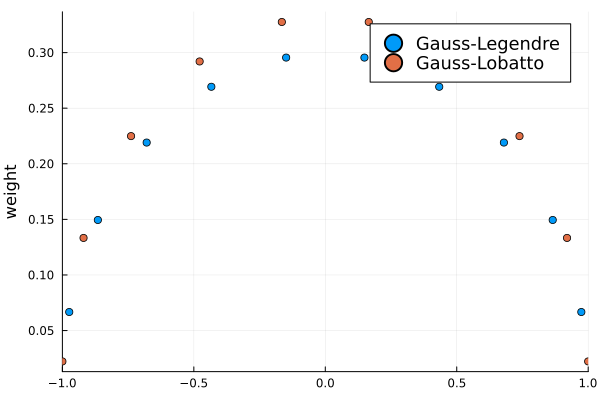

In [2]:
using FastGaussQuadrature

n = 10
x, q = gausslegendre(n)
scatter(x, q, label="Gauss-Legendre", ylabel="weight", xlims=(-1, 1))
scatter!(gausslobatto(n)..., label="Gauss-Lobatto")

[Trefethen, *Six Myths of Polynomial Interpolation and Quadrature*](https://people.maths.ox.ac.uk/trefethen/mythspaper.pdf)

In [3]:
@time gausslegendre(10000000);

  0.182398 seconds (10 allocations: 228.882 MiB, 24.45% gc time)


# Singular integrands

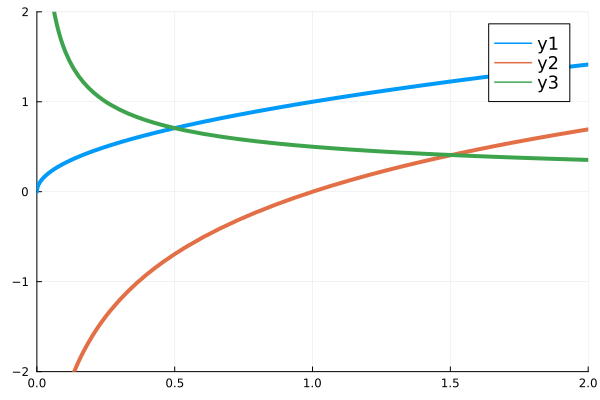

In [4]:
plot([sqrt log x->.5*x^(-.5)], xlim=(0, 2), ylim=(-2, 2))

In [5]:
function fint_gauss(f, a, b, n)
    x, w = gausslegendre(n)
    x = (a+b)/2 .+ (b-a)/2*x
    w *= (b - a)/2
    w' * f.(x)
end

fint_gauss (generic function with 1 method)

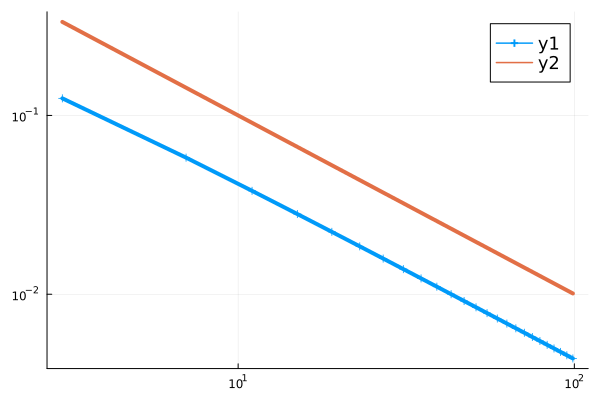

In [23]:
plot(3:4:100, 
    n -> abs(fint_gauss(x -> .5*x^(-.5), 0, 1, n) - 1),
    marker=:auto, yscale=:log10, xscale=:log10)
plot!(n -> 1/n)

# Tanh-Sinh quadrature: make everything smooth

When functions have singularities near the endpoints, it is usually more efficient to integrate via a change of variables.  Suppose we have a strictly monotone differentiable function $\phi: (-\infty, \infty) \to (-1, 1)$.
Then with $x = \phi(s)$, our integral transforms as
$$ \int_{-1}^1 f(x) \mathrm dx = \int_{-\infty}^\infty f(\phi(s)) \phi'(s) \mathrm d s . $$
The tanh-sinh method uses a transformation such that $\phi'(s) \to 0$ faster than the singularity $f(\phi(s))$ grows, such that the integrand goes to 0 at finite $s$.

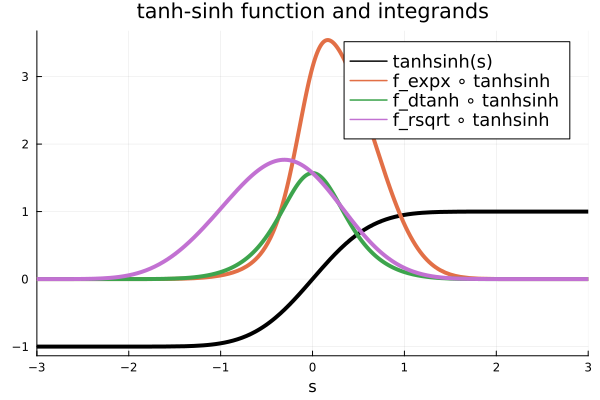

In [25]:
tanhsinh(s) = tanh(pi/2*sinh(s))

function dtanhsinh(s)
    ds = 1
    t = pi/2 * sinh(s)
    dt = pi/2 * cosh(s) * ds
    (1 - tanh(t)^2) * dt
end

p = plot([tanhsinh], color=:black, label="tanhsinh(s)",
    xlims=(-3, 3),
    xlabel="s", title="tanh-sinh function and integrands")
for f in integrands
    plot!(s -> f(tanhsinh(s))*dtanhsinh(s), label="$f ∘ tanhsinh")
end
p

# Implementation

The function below implements tanh-sinh quadrature on the interval $(-1,1)$.  Given the number of points, we need to choose both the limits of integration (we can't afford to integrate all the way to infinity) and the spacing.  Here we make an arbitrary choice to integrate on the interval $(-L, L)$ where $L = \log n$. The grid spacing thus scales as $h \approx 2 \log n / n$.

Modify the quadrature so it can be used to integrate on an arbitrary interval $(a,b)$.

In [26]:
function fint_tanhsinh(f, a, b; n=9)
    L = log(n)
    h = 2 * L / (n - 1)
    s = LinRange(-L, L, n)
    x = tanhsinh.(s)
    w = h * dtanhsinh.(s)
    ## Challenge: modify the weights w and points x to integrated on (a,b), not (-1, 1)
    w' * f.(x)
end

fint_tanhsinh (generic function with 1 method)

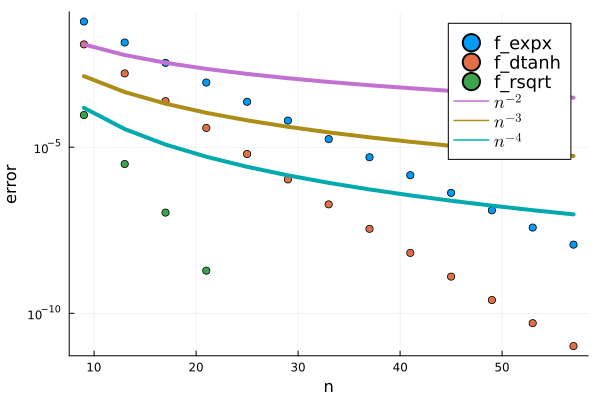

In [29]:
plot_accuracy(fint_tanhsinh, tests, 9:4:60, ref=[2,3,4])
plot!(xscale=:identity,)

In [10]:
# If you complete the challenge above
@assert fint_tanhsinh(log, 0, 1, n=20) ≈ -1
println("Tests pass")

LoadError: DomainError with -0.9999999999999508:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

# Finite Element methods

* Need to integrate the product of basis functions over every element
* Choose a quadrature (e.g., Gauss) to minimize number of points for sufficient accuracy
* Bad effects if insufficient points

# Functions that are rough in the interior

If a function has rough or singular behavior in the interior of the domain, we'll get low accuracy results.

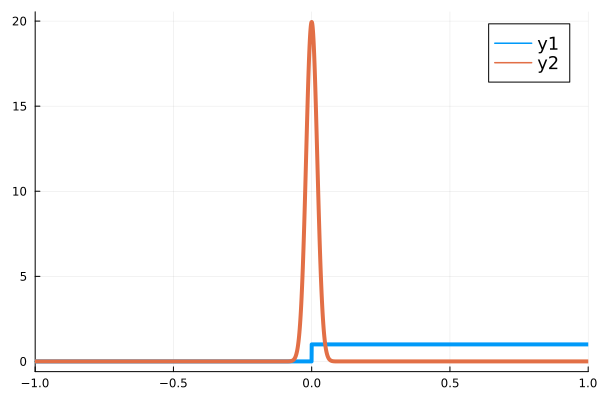

In [34]:
using SpecialFunctions
f_heaviside(x) = 1.0 * (x > 0)
F_heaviside(x) = max(x, 0)
f_mollify(x, sigma=.02) = 1/(sigma * sqrt(2*π)) * exp(-.5*(x/sigma)^2)
F_mollify(x, sigma=.02) = .5*erf(x/(sigma*sqrt(2)))
rough_tests = [(f_heaviside, F_heaviside), (f_mollify, F_mollify)]
plot([f_heaviside, f_mollify], xlim=(-1, 1))

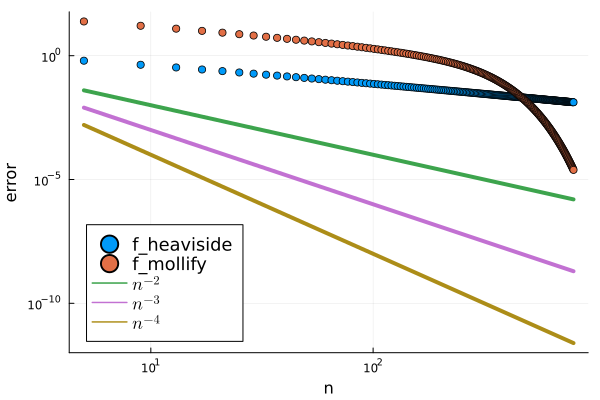

In [37]:
plot_accuracy(fint_tanhsinh, rough_tests, 5:4:800, ref=[2,3,4]); plot!(legend=:bottomleft)

# Adaptive integration

In [43]:
using HCubature

@show F_heaviside(1 - .3) - F_heaviside(-1 - .3)
hquadrature(x -> f_heaviside(x - 0.3), -1, 1, maxevals=1000)

F_heaviside(1 - 0.3) - F_heaviside(-1 - 0.3) = 0.7


(0.700000008169331, 9.264907000048497e-9)

In [48]:
hquadrature(f_mollify, -1, 1, maxevals=1000)

(1.0000000000000004, 6.773758245292121e-10)

In [45]:
F_mollify(1) - F_mollify(-1)

1.0

# Quadrature/cubature for multi-dimensional integration

https://pypi.org/project/quadpy/